## Setup and Loading in Data


In [ ]:
# Libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Google Colaboratory
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

# Sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.feature_selection import SelectFromModel

from statistics import mean, stdev

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Import training data
link = 'https://drive.google.com/open?id=1fOB2cHwSz8PDgxxqRtMd_-N2GCvShhiq'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_call.txt')

# Import training labels
link = 'https://drive.google.com/open?id=1ik34T-2HOMxbJfO2uu8mcsoLbRJfGcJc'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Train_clinical.txt')

In [ ]:
X_train = pd.read_csv('Train_call.txt', sep='\t').transpose()

# Store array info (chromosome, position, n_clone in a different object)
array_info = X_train.head(n=4).to_dict()
X_train = X_train.iloc[4:,]
y_train = pd.read_csv('Train_clinical.txt', sep='\t', index_col=0)

### Split data

In [ ]:
def split_label(data, labeldata):
  labeled_data = {}
  data_cat = data.copy()
  data_cat["label"] = labeldata
  tags = data_cat["label"].unique()

  for tag in tags:
    labeled_data[tag] = data_cat.loc[data_cat['label'] == tag,:]
  return labeled_data

data_dict = split_label(X_train, y_train)
x_train_hr = data_dict['HR+']
x_train_her = data_dict['HER2+']
x_train_tripleN = data_dict['Triple Neg']

print(x_train_hr.shape, x_train_her.shape, x_train_tripleN.shape)

(36, 2835) (32, 2835) (32, 2835)


In [ ]:
#data1, data2, data3 are dataset for each labels, hr+, her+, triplenegative
#frac, ratio = training data/total data
#random_state, random_state of the random splite

def slice_set(data1, data2, data3, frac, random_state):
  train1 = data1.sample(frac = frac,random_state= random_state )
  train2 = data2.sample(frac=frac,random_state=random_state)
  train3 = data3.sample(frac=frac,random_state=random_state)
  training_set = pd.concat([train1, train2, train3], axis=0)
  temp1 = data1.drop(train1.index)
  temp2 = data2.drop(train2.index)
  temp3 = data3.drop(train3.index)
  val1 = temp1.sample(frac = 0.52,random_state=random_state)
  val2 = temp2.sample(frac = 0.52,random_state=random_state)
  val3 = temp3.sample(frac = 0.52,random_state=random_state)
  validation_set = pd.concat([val1, val2, val3], axis=0)
  test1 = temp1.drop(val1.index)
  test2 = temp2.drop(val2.index)
  test3 = temp3.drop(val3.index)
  testing_set = pd.concat([test1, test2, test3], axis=0)
  return training_set, validation_set, testing_set

training, validation, testing = slice_set(x_train_hr, x_train_her, x_train_tripleN, 0.6, 374)

In [ ]:
#training set, validation set, testing set from split. _onehot is onehot encoded labels. 


### Exploratory Data Analysis

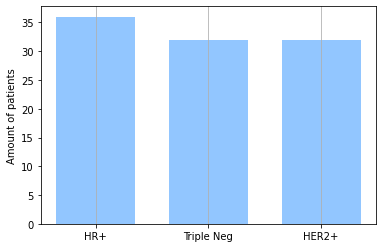

In [ ]:
plt.style.use('seaborn-pastel')

counts = y_train['Subgroup'].value_counts()
names = ['HR+', 'Triple Neg', 'HER2+']
y_pos = [0,0.5,1] 
plt.bar(y_pos, counts, width=0.35)
plt.xticks(y_pos, names)
plt.ylabel('Amount of patients')
plt.grid(b=None, axis='x')
plt.show()

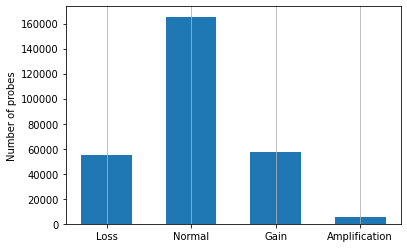

In [ ]:
test = X_train.values
unique, counts = np.unique(test, return_counts=True)
names = ['Loss', 'Normal', 'Gain', 'Amplification']
y_pos = [0,1,2,3] 
plt.bar(y_pos, counts, width=0.6)
plt.xticks(y_pos, names)
plt.ylabel('Number of probes')
plt.grid(b=None, axis='x')
plt.show()

## Feature Extraction and/or Selection

### Feature selecting using feature importances


In [ ]:
#Feature selector package
from sklearn.feature_selection import SelectFromModel

#3 Models to test on
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X = X_train
y = y_train

rf = RandomForestClassifier()
svm = SVC(kernel='linear')
logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')

models = [rf, svm, logreg]

for model in models:
  selector = SelectFromModel(estimator=model, threshold=0).fit(X, np.ravel(y))
  number_of_features = selector.transform(X).shape[1]

  while number_of_features > 10:
    i = selector.threshold
    i += 0.05
    selector = SelectFromModel(estimator=model, threshold= i).fit(X, np.ravel(y))
    number_of_features = selector.transform(X).shape[1]
    if number_of_features <= 10:
      print(selector.get_support(indices=True))

'''
Apparently you can change the threshold within the loop and transform without having to constantly fit the data but I chose to do it explicitly

while number_of_features > 10:
  selector.threshold += 0.05
  number_of_features = selector.transform(X).shape[1]
  print(selector.get_support(indices=True))
'''
  

In [ ]:
selector = SelectFromModel(estimator=logreg, threshold=0).fit(X, np.ravel(y))
number_of_features = selector.transform(X).shape[1]

while number_of_features > 15:
  i = selector.threshold
  i += 0.05
  selector = SelectFromModel(estimator=logreg, threshold= i).fit(X, np.ravel(y))
  number_of_features = selector.transform(X).shape[1]
  if number_of_features <= 15:
    print(selector.get_support(indices=True))

[1243 1956 2182 2183 2184 2185 2186 2770 2771]


In [ ]:
  selector = SelectFromModel(estimator=rf, threshold=0).fit(X, np.ravel(y))
  number_of_features = selector.transform(X).shape[1]

  while number_of_features > 15:
    i = selector.threshold
    i += 0.05
    selector = SelectFromModel(estimator=rf, threshold= i).fit(X, np.ravel(y))
    number_of_features = selector.transform(X).shape[1]
    if number_of_features <= 10:
      print(selector.get_support(indices=True))

In [ ]:
  selector = SelectFromModel(estimator=svm, threshold=0).fit(X, np.ravel(y))
  number_of_features = selector.transform(X).shape[1]

  while number_of_features > 15:
    i = selector.threshold
    i += 0.05
    selector = SelectFromModel(estimator=svm, threshold= i).fit(X, np.ravel(y))
    number_of_features = selector.transform(X).shape[1]
    if number_of_features <= 15:
      print(selector.get_support(indices=True))

[1243 1956 2182 2183 2184 2185 2186 2379 2515 2770 2771]


In [ ]:
y_train_no_HER2 = y_training[y_training != 'HER2+']
indices = y_train_no_HER2.index
X_train_no_HER2 = x_training.loc[indices, :]

for model in models:
  selector = SelectFromModel(estimator=model, threshold=0).fit(X_train_no_HER2, np.ravel(y_train_no_HER2))
  number_of_features = selector.transform(X_train_no_HER2).shape[1]

  while number_of_features > 20:
    i = selector.threshold
    i += 0.05
    selector = SelectFromModel(estimator=model, threshold= i).fit(X_train_no_HER2, np.ravel(y_train_no_HER2))
    number_of_features = selector.transform(X_train_no_HER2).shape[1]
    if number_of_features <= 50:
      print(selector.get_support(indices=True))

#[486, 695, 1243, 1654, 1678, 2024, 2184, 2213, 2750]
selected_features = [192, 226, 1243, 2182, 2183, 2184, 2185, 2186, 1604, 2742]

[]
[]
[  39   40  305  432  689  722  772  791 1060 1061 1062 1066 1243 1457
 1563 1566 1567 1672 1674 1675 1869 1901 1902 1956 2014 2015 2016 2017
 2018 2019 2020 2022 2023 2024 2026 2027 2034 2039 2040 2464 2770 2771]
[]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [ ]:
np.ravel(y_train_no_HER2)

array(['HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+',
       'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+', 'HR+',
       'HR+', 'HR+', 'HR+', 'HR+', 'Triple Neg', 'Triple Neg',
       'Triple Neg', 'Triple Neg', 'Triple Neg', 'Triple Neg',
       'Triple Neg', 'Triple Neg', 'Triple Neg', 'Triple Neg',
       'Triple Neg', 'Triple Neg', 'Triple Neg', 'Triple Neg',
       'Triple Neg', 'Triple Neg', 'Triple Neg', 'Triple Neg',
       'Triple Neg'], dtype=object)

In [ ]:
x_train = pd.read_csv('Train_call.txt', sep='\t').transpose()

# Store array info (chromosome, position, n_clone in a different object)
array_info = x_train.head(n=4).to_dict()
x_train = x_train.iloc[4:,]
y_train = pd.read_csv('Train_clinical.txt', sep='\t', index_col=0)

# these seem the 10 best features
x_train_select = pd.read_csv('Train_call.txt', sep='\t').transpose()

# Store array info (chromosome, position, n_clone in a different object)
array_info_select = x_train_select.head(n=4).to_dict()
x_train_10features = x_train_select.iloc[:,[192, 226, 1243, 2182, 2183, 2184, 2185, 2186, 1604, 2742]]
x_train_10features = x_train_10features.iloc[4:,]

y_train = pd.read_csv('Train_clinical.txt', sep='\t', index_col=0)
x_train_10features.shape

def split_label(data, labeldata):
  labeled_data = {}
  data_cat = data.copy()
  label = labeldata.copy()
  #label = label.set_index(labeldata.iloc[:,0])
  data_cat["label"] = label['Subgroup']
  tags = data_cat["label"].unique()

  for tag in tags:
    labeled_data[tag] = data_cat.loc[data_cat['label'] == tag,:]
  return labeled_data

data_dict = split_label(x_train_10features, y_train)
x_train_hr = data_dict['HR+']
x_train_her = data_dict['HER2+']
x_train_tripleN = data_dict['Triple Neg']

print(x_train_hr.shape, x_train_her.shape, x_train_tripleN.shape)

#data1, data2, data3 are dataset for each labels, hr+, her+, triplenegative
#frac, ratio = training data/total data
#random_state, random_state of the random splite

def slice_set(data1, data2, data3, frac, random_state):
  train1 = data1.sample(frac = frac,random_state= random_state )
  train2 = data2.sample(frac=frac,random_state=random_state)
  train3 = data3.sample(frac=frac,random_state=random_state)
  training_set = pd.concat([train1, train2, train3], axis=0)
  temp1 = data1.drop(train1.index)
  temp2 = data2.drop(train2.index)
  temp3 = data3.drop(train3.index)
  val1 = temp1.sample(frac = 0.5,random_state=random_state)
  val2 = temp2.sample(frac = 0.5,random_state=random_state)
  val3 = temp3.sample(frac = 0.5,random_state=random_state)
  validation_set = pd.concat([val1, val2, val3], axis=0)
  test1 = temp1.drop(val1.index)
  test2 = temp2.drop(val2.index)
  test3 = temp3.drop(val3.index)
  testing_set = pd.concat([test1, test2, test3], axis=0)
  return training_set, validation_set, testing_set

training, validation, testing = slice_set(x_train_hr, x_train_her, x_train_tripleN, 0.6, 10)

#training set, validation set, testing set from split. _onehot is onehot encoded labels. 

x_training = training.iloc[:,:-1]
y_training_onehot = pd.get_dummies(training['label'])
y_training = training['label']

x_validation = validation.iloc[:,:-1]
y_validation_onehot = pd.get_dummies(validation['label'])
y_validation = validation['label']

x_testing = testing.iloc[:,:-1]
y_testing_onehot = pd.get_dummies(testing['label'])
y_testing = testing['label']

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=y_validation) # removed labels=my_tags... what is y_true in this case??
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    print(classification_report(target, predictions)) 

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized', y_true=y_validation) # what is y_true here? is it: y_true=y_validation_2 ?

(36, 11) (32, 11) (32, 11)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
rf = RandomForestClassifier()
svm = SVC(kernel='linear')
logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')

clf = logreg.fit(x_training, y_training)
y_pred = clf.predict(x_training)
print('accuracy %s' % accuracy_score(y_pred, y_training))
print(classification_report(y_training, y_pred))

accuracy 0.75
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00        19
         HR+       0.65      0.68      0.67        22
  Triple Neg       0.61      0.58      0.59        19

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



In [ ]:
y_pred = clf.predict(x_validation)
print('accuracy %s' % accuracy_score(y_pred, y_validation))
print(classification_report(y_validation, y_pred))

accuracy 0.7894736842105263
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         6
         HR+       0.71      0.71      0.71         7
  Triple Neg       0.67      0.67      0.67         6

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



In [ ]:
clf = rf.fit(x_training, y_training)
y_pred = clf.predict(x_training)
print('accuracy %s' % accuracy_score(y_pred, y_training))
print(classification_report(y_training, y_pred))

accuracy 0.9833333333333333
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00        19
         HR+       1.00      0.95      0.98        22
  Triple Neg       0.95      1.00      0.97        19

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [ ]:
y_pred = clf.predict(x_validation)
print('accuracy %s' % accuracy_score(y_pred, y_validation))
print(classification_report(y_validation, y_pred))

accuracy 0.7368421052631579
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         6
         HR+       0.67      0.57      0.62         7
  Triple Neg       0.57      0.67      0.62         6

    accuracy                           0.74        19
   macro avg       0.75      0.75      0.74        19
weighted avg       0.74      0.74      0.74        19



In [ ]:
clf = svm.fit(x_training, y_training)
y_pred = clf.predict(x_training)
print('accuracy %s' % accuracy_score(y_pred, y_training))
print(classification_report(y_training, y_pred))

accuracy 0.7833333333333333
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00        19
         HR+       0.66      0.86      0.75        22
  Triple Neg       0.75      0.47      0.58        19

    accuracy                           0.78        60
   macro avg       0.80      0.78      0.78        60
weighted avg       0.79      0.78      0.77        60



In [ ]:
y_pred = clf.predict(x_validation)
print('accuracy %s' % accuracy_score(y_pred, y_validation))
print(classification_report(y_validation, y_pred))

accuracy 0.7894736842105263
              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         6
         HR+       0.67      0.86      0.75         7
  Triple Neg       0.75      0.50      0.60         6

    accuracy                           0.79        19
   macro avg       0.81      0.79      0.78        19
weighted avg       0.80      0.79      0.78        19



In [ ]:
n = range(0, 2834, 10)
n_list = []
score_list = []
stdev_list = []
for i in n:
  if i == 0:
    i = 1
  logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')
  selector = SelectFromModel(logreg, prefit=False, max_features=i)
  pipe = Pipeline(steps=[('feature_extraction', selector), ('logistic', logreg)])
  scoring = cross_validate(pipe, X_train, np.ravel(y_train), cv=3)
  n_list.append(i)
  score_list.append(mean(scoring['test_score']))
  stdev_list.append(stdev(scoring['test_score']))

results_dict = {'Number of features': n_list, 'Accuracy': score_list, 'Standard deviation': stdev_list}
results_df = pd.DataFrame(results_dict)

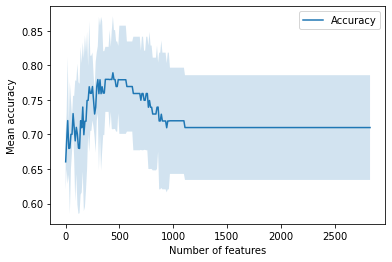

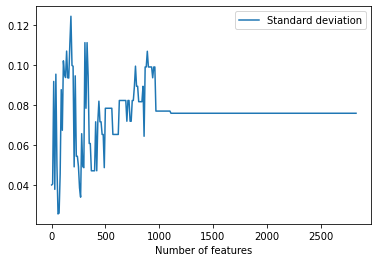

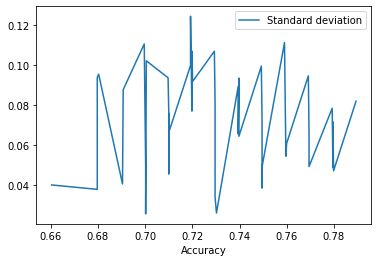

In [ ]:
results_df.plot('Number of features', 'Accuracy')
plt.fill_between(results_df['Number of features'].astype(np.float),
                 results_df['Accuracy'] + results_df['Standard deviation'],
                 results_df['Accuracy'] - results_df['Standard deviation'], alpha=0.2)

plt.ylabel("Mean accuracy")
plt.xlabel("Number of features")


results_df.plot('Number of features', 'Standard deviation')
results_df.sort_values(by=['Accuracy']).plot('Accuracy', 'Standard deviation')

### Feature selection using recursive feature elimination (RFE)

RFE basically does the approach as shown above but 3x on the entire dataset instead of measuring every threshold for every split

In [ ]:
# Warning: takes > 15 min. with current settings
from sklearn.feature_selection import RFECV

logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')
rfe = RFECV(logreg,step=1, cv=3, verbose=10)
rfe.fit(X_train, np.ravel(y_train))

# Transform and format output correctly
features = rfe.get_support(indices=True) 
features = [column for column in X_train[features]] 
X_train_logreg_rfe = pd.DataFrame(rfe.transform(X_train), index=X_train.index)
X_train_logreg_rfe.columns = features

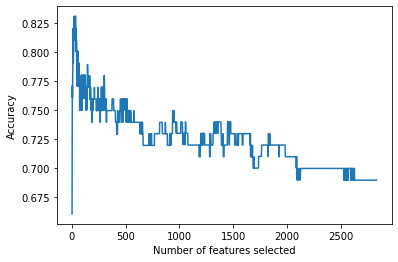

In [ ]:
# Visualize RFE

plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [ ]:
X_train_logreg_rfe.shape

(100, 29)

In [ ]:
X_train_logreg_rfe.columns

Int64Index([ 192,  432,  486,  695,  765,  791,  854,  999, 1061, 1243, 1559,
            1569, 1655, 1656, 1677, 1678, 1900, 1902, 1973, 2024, 2026, 2184,
            2210, 2213, 2214, 2547, 2742, 2750, 2760],
           dtype='int64')

In [ ]:
# Optimize models with RFE Logreg results

# Logistic Regression
param = {"C": range(1,30)}
logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')
grid = GridSearchCV(logreg, param_grid=param, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train_rfe, np.ravel(y_train))

cv_results = cross_validate(grid, X_train_rfe, np.ravel(y_train), cv=3)
print(cv_results['test_score'])
print(mean(cv_results['test_score']))

[1.         0.93939394 0.96969697]
0.9696969696969697


In [ ]:
# LinearSVM
from sklearn.svm import LinearSVC
param = {"C": np.logspace(-3,3,7)}
linsvc = LinearSVC(max_iter=10000)
grid = GridSearchCV(linsvc, param_grid=param, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train_rfe, np.ravel(y_train))

cv_results = cross_validate(grid, X_train_rfe, np.ravel(y_train), cv=3)
print(cv_results['test_score'])
print(mean(cv_results['test_score']))

[1. 1. 1.]
1.0


In [ ]:
# Random Forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=42)
grid = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=3, random_state=42, n_jobs = -1, return_train_score=True)
grid.fit(X_train_rfe, np.ravel(y_train))

cv_results = cross_validate(grid, X_train_rfe, np.ravel(y_train), cv=3)
print(cv_results['test_score'])
print(mean(cv_results['test_score']))

[0.88235294 0.81818182 0.93939394]
0.8799762329174095


In [ ]:
# LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

cv_results = cross_validate(lda, X_train_rfe, np.ravel(y_train), cv=3)
print(cv_results['test_score'])
print(mean(cv_results['test_score']))

[0.91176471 0.93939394 0.93939394]
0.9301841948900773


# Component analysis (normal PCA, truncated svd, or more)


## RFE and random forest

In [ ]:
# Warning: takes > 15 min. with current settings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

randomforest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
rfe_rf = RFECV(randomforest,step=1, cv=3)
rfe_rf.fit(x_training, np.ravel(y_training))

# Transform and format output correctly
features_rf = rfe_rf.get_support(indices=True) 
features_rf = [column for column in x_training[features_rf]] 
x_training_rfe_rf = pd.DataFrame(rfe_rf.transform(x_training), index=x_training.index)
x_training_rfe_rf.columns = features_rf


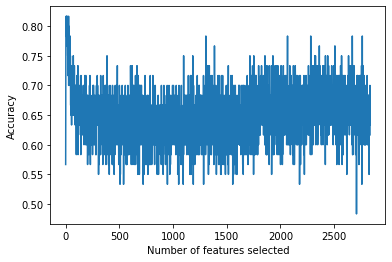

In [ ]:
# Visualize RFE

plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfe_rf.grid_scores_) + 1), rfe_rf.grid_scores_)
plt.show()

In [ ]:
x_training_rfe_rf.columns

Int64Index([772, 818, 1656, 2184, 2547], dtype='int64')

In [ ]:
x_training_rf = x_training.iloc[:,X_train_rfe_rf.columns]
x_validation_rf = x_validation.iloc[:,X_train_rfe_rf.columns]

## Truncatedsvd

### Dimension Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=4, n_iter=10, random_state=21)
svd_training = svd.fit_transform(x_training)
print('Explained variation per principal component: {}'.format(svd.explained_variance_ratio_))

svd_validation = svd.transform(x_validation)
svd_testing = svd.transform(x_validation)

Explained variation per principal component: [0.04090328 0.16560166 0.05718807 0.04516835]


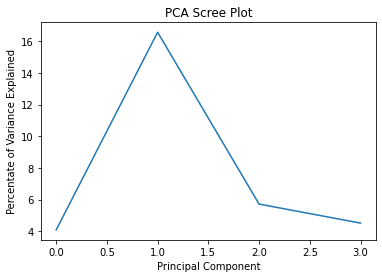

In [ ]:
percent_variance = np.round(svd.explained_variance_ratio_* 100, decimals =2)
columns = range(len(svd.explained_variance_ratio_))
plt.plot(columns,percent_variance)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

### Test on models

In [ ]:
targets = np.array(y_train)
my_tags = np.unique(targets)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    print(classification_report(target, predictions)) 

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

#### Logreg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


accuracy 0.5238095238095238
confusion matrix
 [[3 3 1]
 [0 6 1]
 [0 5 2]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

       HER2+       1.00      0.43      0.60         7
         HR+       0.43      0.86      0.57         7
  Triple Neg       0.50      0.29      0.36         7

    accuracy                           0.52        21
   macro avg       0.64      0.52      0.51        21
weighted avg       0.64      0.52      0.51        21



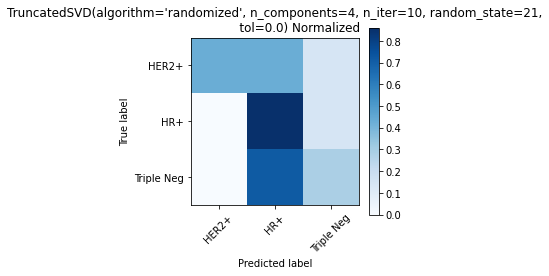

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import linear_model



#linear regression model
logreg = linear_model.LogisticRegression(penalty = "l2", max_iter= 600, n_jobs=1, C=1e5, verbose=1)
logreg = logreg.fit(svd_training , y_training)
#evaluation of model
evaluate_prediction(logreg.predict(svd_validation),y_validation, title=str(logreg))

#### LinearSVM

accuracy 0.5238095238095238
confusion matrix
 [[3 3 1]
 [0 6 1]
 [0 5 2]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

       HER2+       1.00      0.43      0.60         7
         HR+       0.43      0.86      0.57         7
  Triple Neg       0.50      0.29      0.36         7

    accuracy                           0.52        21
   macro avg       0.64      0.52      0.51        21
weighted avg       0.64      0.52      0.51        21



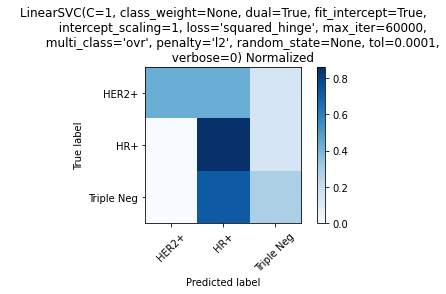

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(penalty= 'l2',  max_iter= 60000, C = 1)
svc.fit(svd_training, y_training)

#evaluation of model
evaluate_prediction(svc.predict(svd_validation),y_validation, title=str(svc))

#### Random forest

accuracy 0.5238095238095238
confusion matrix
 [[3 2 2]
 [0 7 0]
 [1 5 1]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

       HER2+       0.75      0.43      0.55         7
         HR+       0.50      1.00      0.67         7
  Triple Neg       0.33      0.14      0.20         7

    accuracy                           0.52        21
   macro avg       0.53      0.52      0.47        21
weighted avg       0.53      0.52      0.47        21



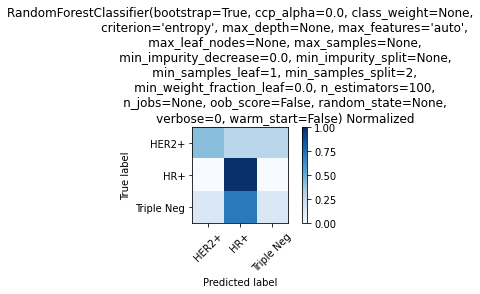

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100, criterion= 'entropy')
rfc.fit(svd_training, y_training)
#evaluation of model
evaluate_prediction(rfc.predict(svd_validation),y_validation, title=str(rfc))

#### LDA

accuracy 0.5238095238095238
confusion matrix
 [[3 3 1]
 [0 6 1]
 [0 5 2]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

       HER2+       1.00      0.43      0.60         7
         HR+       0.43      0.86      0.57         7
  Triple Neg       0.50      0.29      0.36         7

    accuracy                           0.52        21
   macro avg       0.64      0.52      0.51        21
weighted avg       0.64      0.52      0.51        21



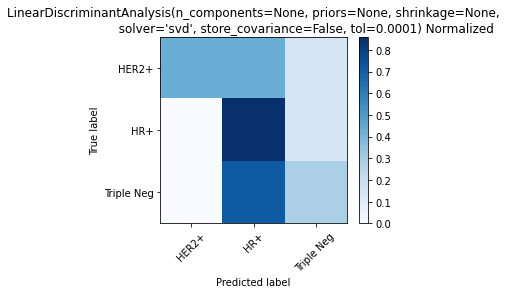

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(svd_training, y_training)
#evaluation of model
evaluate_prediction(lda.predict(svd_validation),y_validation, title=str(lda))

##***PCA***

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 30)
training_pca = pca.fit_transform(x_training)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.19655596 0.0691948  0.05000614 0.04442639 0.0399946  0.03453403
 0.03407377 0.02948123 0.02790015 0.02603419 0.02446941 0.02138788
 0.0210545  0.02002065 0.01730303 0.01665723 0.01634774 0.01594226
 0.01514719 0.01459754 0.01402016 0.0137827  0.01267649 0.01228242
 0.01181217 0.01163216 0.01085576 0.01036338 0.0102089  0.01002987]


## ***PLS Regression***

In [ ]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=50)
pls2.fit(x_training, y_training_onehot)
pls_training = pls2.x_scores_
pls_validation = pls2.transform(x_validation)

## test

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression(max_iter=10000, penalty='l2')
clf = logreg.fit(X_train, y_train['Subgroup'])
y_pred = clf.predict(X_train)
print('accuracy %s' % accuracy_score(y_pred, y_train['Subgroup']))
print(classification_report(y_train['Subgroup'], y_pred)) 



In [ ]:
feature_selected = [41, 42, 44, 48, 192, 194, 226, 229, 230, 305, 396, 415, 432, 486, 546, 599, 600, 669, 674, 689, 695, 696, 697, 744, 745, 746, 758, 765, 771, 790, 791, 792, 1009, 1057, 1059, 1060, 1061, 1079, 1243, 1551, 1558, 1559, 1560, 1561, 1562, 1563, 1567, 1569, 1604, 1642, 1643, 1646, 1651, 1655, 1656, 1657, 1663, 1664, 1671, 1672, 1673, 1674, 1675, 1677, 1678, 1679, 1680, 1681, 1684, 1713, 1816, 1869, 1877, 1895, 1896, 1900, 1902, 1956, 1959, 1962, 1972, 1973, 1996, 2016, 2017, 2018, 2021, 2022, 2023, 2024, 2026, 2027, 2030, 2032, 2044, 2045, 2218, 2329, 2382, 2383, 2384, 2420, 2421, 2422, 2423, 2428, 2465, 2528, 2547, 2548, 2552, 2593, 2608, 2736, 2742, 2747, 2748, 2749, 2750, 2752, 2760, 2213, 2184]

In [ ]:
feature_selected = [ 192,  432,  486,  695,  765,  791,  854,  999, 1061, 1243, 1559,
            1569, 1655, 1656, 1677, 1678, 1900, 1902, 1973, 2024, 2026, 2184,
            2210, 2213, 2214, 2547, 2742, 2750, 2760]

In [ ]:
X_train_selected = X_train.loc[:,feature_selected]
X_train_selected.shape

(100, 29)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
logreg = LogisticRegression(max_iter=10000, penalty='l2', solver='lbfgs')

kf = RepeatedStratifiedKFold(n_splits=4, n_repeats= 300, random_state=None)
fold_accuracy = []
for train_index, test_index in kf.split(X_train_selected, y_train):
      x_training, x_validation = X_train_selected.iloc[train_index,:], X_train_selected.iloc[test_index,:] 
      y_training, y_validation = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
      clf = logreg.fit(x_training, y_training)
      y_pred = clf.predict(x_validation)
      fold_accuracy.append(accuracy_score(y_pred, y_validation))
      print('accuracy %s' % accuracy_score(y_pred, y_validation))
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

##***Plots***

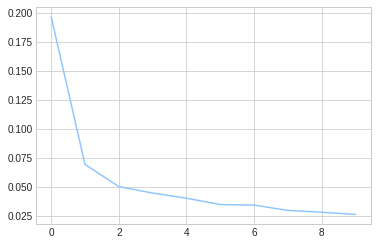

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

explained_ratio = pca #truncated svd or pca, 
plt.plot([x for x in range(len(explained_ratio.explained_variance_ratio_))], explained_ratio.explained_variance_ratio_)

In [ ]:
component_data = svd_data
explained_ratio = svd

plt.figure(figsize=(20, 10))
scatterplot = sns.scatterplot(component_data[:,0],component_data[:,1], hue = y_training, sizes = 200)
scatterplot.set_xlabel('Component 1 ({:.0%})'.format(explained_ratio.explained_variance_ratio_[0]))
scatterplot.set_ylabel('Component 2 ({:.0%}'.format(explained_ratio.explained_variance_ratio_[1]))

# K Folds CV


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
kf = KFold(n_splits=4, random_state=None, shuffle=True)
fold_accuracy = []
for train_index, test_index in kf.split(X_train, y_train):
      x_training, x_validation = X_train.iloc[train_index,:], X_train.iloc[test_index,:] 
      y_training, y_validation = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
      clf = clf.fit(x_training, y_training)
      y_pred = clf.predict(x_validation)
      fold_accuracy.append(accuracy_score(y_pred, y_validation))
      print('accuracy %s' % accuracy_score(y_pred, y_validation))
      print(classification_report(y_validation, y_pred)) 
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


accuracy 0.64
              precision    recall  f1-score   support

       HER2+       1.00      0.64      0.78        11
         HR+       0.67      0.50      0.57         8
  Triple Neg       0.42      0.83      0.56         6

    accuracy                           0.64        25
   macro avg       0.69      0.66      0.63        25
weighted avg       0.75      0.64      0.66        25

accuracy 0.68
              precision    recall  f1-score   support

       HER2+       0.62      0.71      0.67         7
         HR+       0.67      0.73      0.70        11
  Triple Neg       0.80      0.57      0.67         7

    accuracy                           0.68        25
   macro avg       0.70      0.67      0.68        25
weighted avg       0.69      0.68      0.68        25



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


accuracy 0.92
              precision    recall  f1-score   support

       HER2+       0.88      1.00      0.93         7
         HR+       1.00      0.82      0.90        11
  Triple Neg       0.88      1.00      0.93         7

    accuracy                           0.92        25
   macro avg       0.92      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25

accuracy 0.4
              precision    recall  f1-score   support

       HER2+       0.67      0.57      0.62         7
         HR+       0.29      0.83      0.43         6
  Triple Neg       0.50      0.08      0.14        12

    accuracy                           0.40        25
   macro avg       0.49      0.50      0.40        25
weighted avg       0.50      0.40      0.35        25

Average accuracy:  0.66


In [ ]:

y_training[28][5]

IndexError: ignored

# SVM


In [ ]:
# Warning: takes > 15 min. with current settings
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
import seaborn as sns

svm = SVC(kernel='linear')
rfe_svm = RFECV(svm,step=1, cv=3, verbose=10)
rfe_svm.fit(X_train, np.ravel(y_train))





In [ ]:
# Transform and format output correctly
features_svm = rfe_svm.get_support(indices=True) 
features_svm = [column for column in X_train[features_svm]] 
X_train_rfe_svm = pd.DataFrame(rfe_svm.transform(X_train), index=X_train.index)
X_train_rfe_svm.columns = features_svm

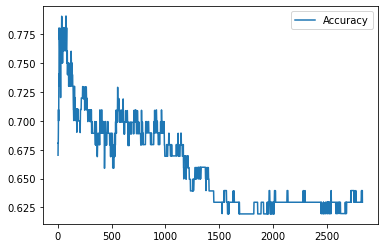

In [ ]:
length = np.arange(1, len(rfe_svm.grid_scores_) + 1)
sns.lineplot(length , rfe_svm.grid_scores_, label="Accuracy")


# Plots

## Venn

In [ ]:
from itertools import chain
from collections import Iterable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import math

default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]
default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
    for i in default_colors
]

def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(
        xy=(x, y),
        width=w,
        height=h,
        angle=a,
        color=fillcolor)
    ax.add_patch(e)

def name_process(text):
  list_text = list(text)
  if list_text[0] == '1':
      list_text[0] = 'l'
  if list_text[1] == '1':
      list_text[1] = 'm'
  if list_text[2] == '1':
      list_text[2] = 's'
  if list_text[3] == '1':
      list_text[3] = 'r'
  text_processed = ''.join(list_text)
  return text_processed

def text_process(text):
  text_split = text.split()
  if len(text_split) >1:
    text_name = text_split[0]
    text_number = text_split[1][0]
    text_set = text_split[1][1:]
    text_set_rest = ''.join(text_split[2:])
    text_set = text_set + text_set_rest
    if text_set == "set()":
      text_set = 'No common feature'
    text_name = name_process(text_name)
    text = text_name + " "+ text_number + "\n" + text_set
  return text

def draw_text(fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=16, ha="center", va="center"):
    text = text_process(text)
    ax.text(
        x, y, text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black")

def draw_annotate(fig, ax, x, y, textx, texty, text, color=[0, 0, 0, 1], arrowcolor=[0, 0, 0, 0.3]):
    plt.annotate(
        text,
        xy=(x, y),
        xytext=(textx, texty),
        arrowprops=dict(color=arrowcolor, shrink=0, width=0.5, headwidth=8),
        fontsize=14,
        color=color,
        xycoords="data",
        textcoords="data",
        horizontalalignment='center',
        verticalalignment='center'
    )

def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data
    @type data: list[Iterable]
    @rtype: dict[str, str]
    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]
    return
      labels: a dict of labels for different sets
    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))                     # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)
    if "data" in fill:
      for k in set_collections:
            labels[k] += str(set_collections[k]).strip('[]')

    return labels

def venn4(labels, names=['A', 'B', 'C', 'D'], **options):
    """
    plots a 4-set Venn diagram
    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)
    input
      labels: a label dict where keys are identified via binary codes ('0001', '0010', '0100', ...),
              hence a valid set could look like: {'0001': 'text 1', '0010': 'text 2', '0100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize
    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(4)])
    figsize = options.get('figsize', (12, 12))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 8)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get('0001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get('0010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get('0011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get('0100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get('0101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get('0110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get('0111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get('1000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get('1001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get('1010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get('1011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get('1100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get('1101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get('1110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get('1111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.13, 0.18, names[0], colors[0], fontsize=fontsize + 8, ha="right")
    draw_text(fig, ax, 0.18, 0.83, names[1], colors[1], fontsize=fontsize + 8, ha="right", va="bottom")
    draw_text(fig, ax, 0.82, 0.83, names[2], colors[2], fontsize=fontsize + 8, ha="left", va="bottom")
    draw_text(fig, ax, 0.87, 0.18, names[3], colors[3], fontsize=fontsize + 8, ha="left", va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

In [ ]:
Adam = set([1243,1956, 2183,2182,2184,2185,2186,2770,2771])
Tim = set([695, 791, 1243, 1563, 2027, 2184, 1563, 2027, 2184, 2213,2548, 2750])
Sal = set([695,765,1901,2184,2210])
Ren2 = set([772, 818, 1656, 2184, 2547])

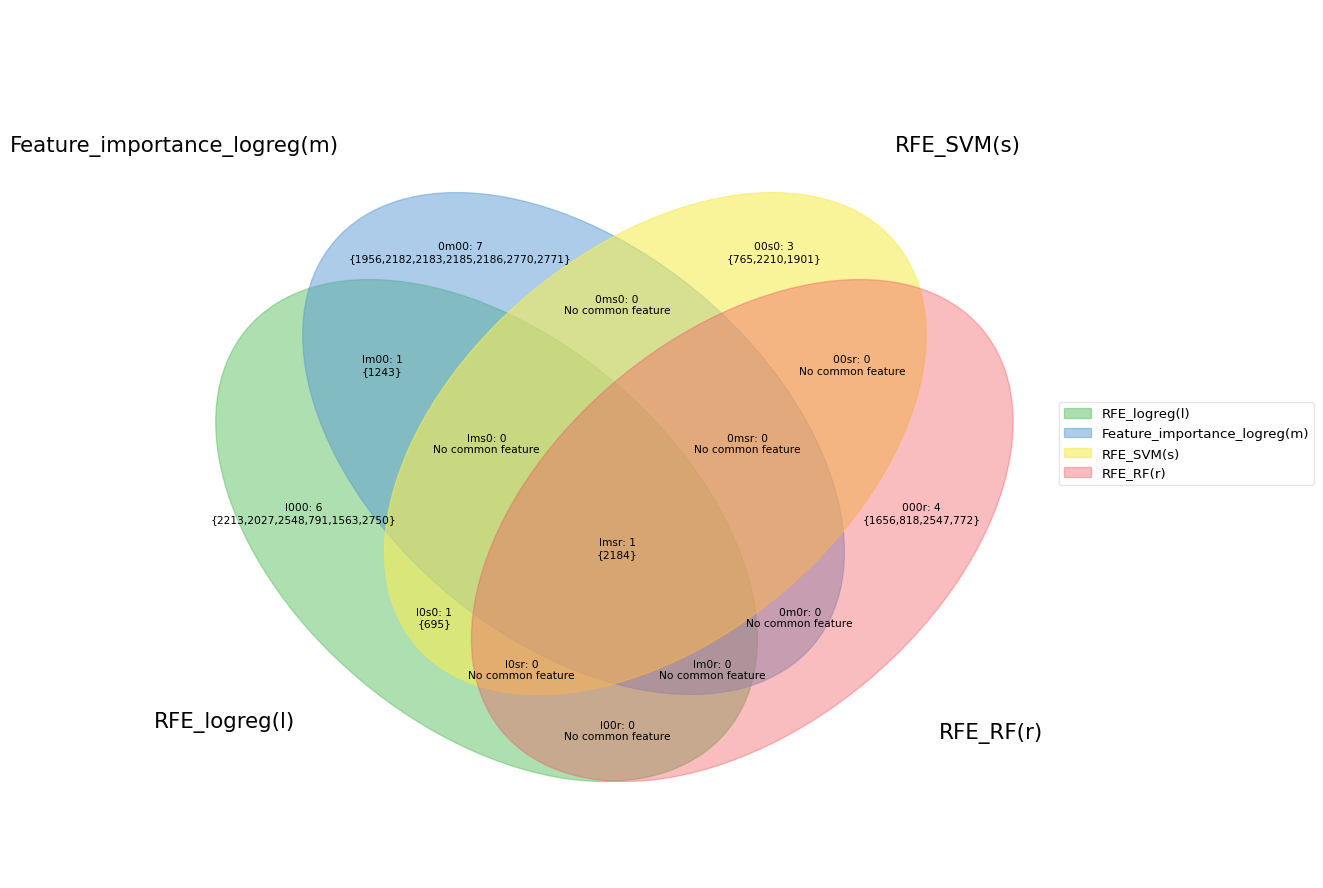

In [ ]:
labels = get_labels([Tim, Adam, Sal, Ren2], fill=['data', 'logic', 'number'])
fig, ax = venn4(labels, names=['RFE_logreg(l)', 'Feature_importance_logreg(m)', 'RFE_SVM(s)', 'RFE_RF(r)'])
fig.show()

## Heatmaps

In [ ]:
feature_selected_sal = [485, 695, 1654, 1678, 2024, 2184, 2213,  2750, 2158] # Sal choosed
feature_selected_common = [1243,1678,2024,2184,2213] #from venn diagram
feature_selected_adam = [192,226,1243,2183,2182,2184,2185,2186,1604,2742]

In [ ]:
X_train_selected = X_train.loc[:,feature_selected_adam]
X_train_selected.shape

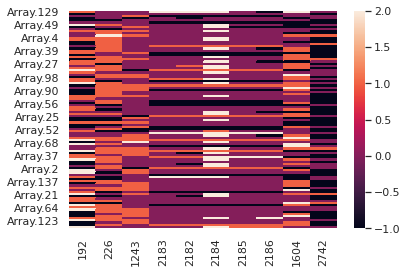

In [ ]:
import seaborn as sns; sns.set()

X_train_selected = X_train_selected[X_train_selected.columns].astype(int)
sns.heatmap(X_train_selected)

In [ ]:
def split_label(data, labeldata):
  labeled_data = {}
  data_cat = data.copy()
  data_cat["label"] = labeldata
  tags = data_cat["label"].unique()

  for tag in tags:
    labeled_data[tag] = data_cat.loc[data_cat['label'] == tag,:]
  return labeled_data

data_dict = split_label(X_train_selected, y_train)
x_train_hr_selected = data_dict['HR+']
x_train_her_selected = data_dict['HER2+']
x_train_tripleN_selected = data_dict['Triple Neg']

print(x_train_hr.shape, x_train_her.shape, x_train_tripleN.shape)

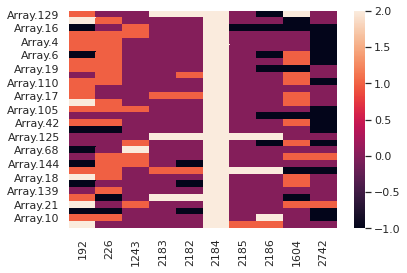

In [ ]:
x_train_her_selected = x_train_her_selected
sns.heatmap(x_train_her_selected)

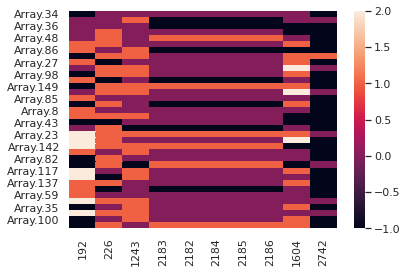

In [ ]:
x_train_hr_selected = x_train_hr_selected
sns.heatmap(x_train_hr_selected,vmin=-1, vmax=2)

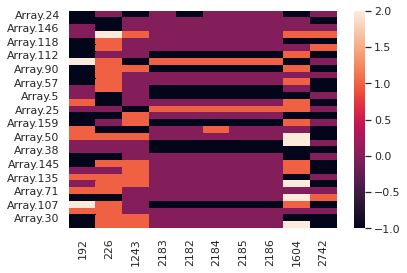

In [ ]:
x_train_tripleN_selected = x_train_tripleN_selected
sns.heatmap(x_train_tripleN_selected,vmin=-1, vmax=2)

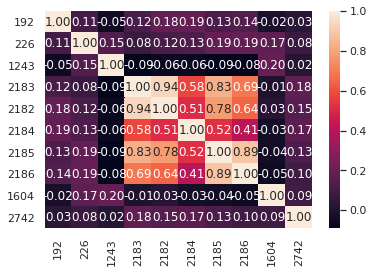

In [ ]:
sns.heatmap(X_train_selected.corr(), annot=True, fmt=".2f")
